In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles,make_moons
from sklearn.neighbors import KernelDensity
from gsw.gsw import GSW
from gsw.gsw_utils import w2
import torch

In [2]:
device=torch.device('cpu')

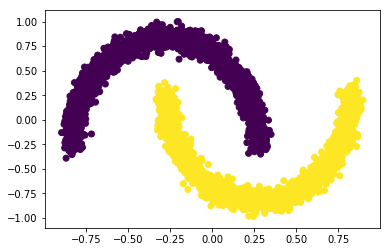

In [3]:
# X,Y=make_circles(5000,noise=.05,factor=.4)
X,Y=make_moons(5000,noise=.05)
X[:,1]*=2
X-=X.mean(0)[np.newaxis,:]
X/=abs(X).max()

plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [4]:
gridx,gridy=np.meshgrid(np.linspace(-1.2,1.2,num=100),np.linspace(-1.2,1.2,num=100))
gridvec = np.concatenate((np.reshape(gridx,(10000,1)),np.reshape(gridy,(10000,1))),1)

In [5]:
ind=np.argwhere(Y==0).squeeze()
z1=X[ind,:].copy()
ind=np.argwhere(Y==1).squeeze()
z2=X[ind,:].copy()

kde1=KernelDensity(bandwidth=1e-1).fit(z1)
Z1=np.exp(kde1.score_samples(gridvec)).reshape((100,100))
kde2=KernelDensity(bandwidth=1e-1).fit(z2)
Z2=np.exp(kde2.score_samples(gridvec)).reshape((100,100))

z1=z1[:100,...]
z2=z2[:100,...]

In [6]:
from gsw.mlp import MLP
import torch.optim as optim

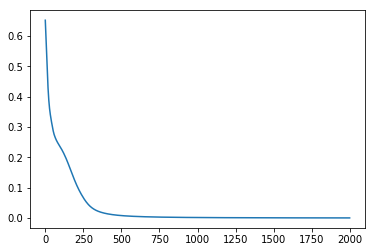

In [7]:
iterations=2000
depth=1
model=MLP(din=2,dout=2,num_filters=7,depth=depth)
optimizer=optim.Adam(model.parameters(),lr=1e-2)
total_loss=np.zeros((iterations,))
criterion=torch.nn.CrossEntropyLoss()



z1trch=torch.from_numpy(z1).type(torch.FloatTensor)
z2trch=torch.from_numpy(z2).type(torch.FloatTensor)

xin=torch.cat([z1trch,z2trch])
yin=torch.cat([torch.zeros((z1trch.shape[0])),
               torch.ones((z2trch.shape[0]))]).type(torch.LongTensor)

for i in range(iterations):
    optimizer.zero_grad()
    z=model(xin)
    loss=criterion(z,yin)
    total_loss[i]=loss.item()
    loss.backward()
    optimizer.step()

plt.plot(total_loss)
plt.show()

Text(0.5,0,'$t$')

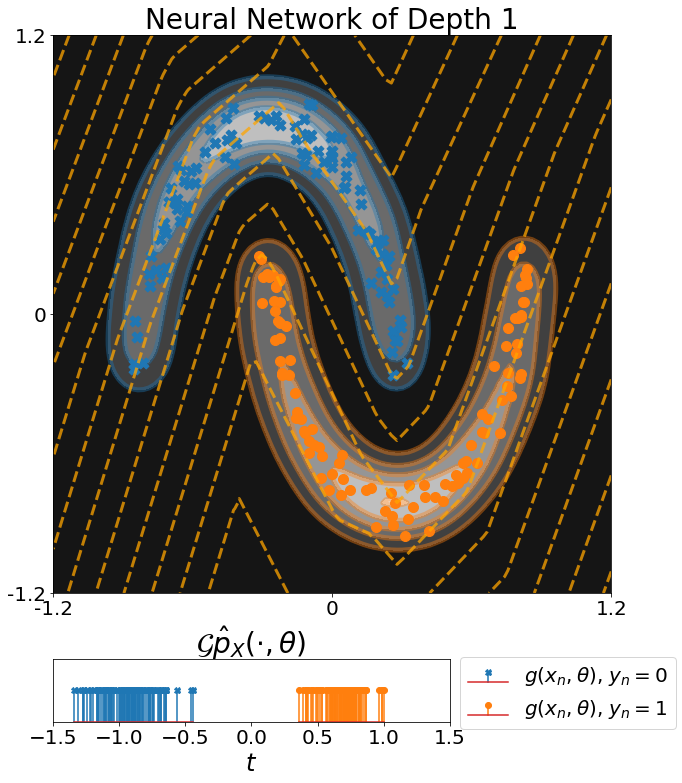

In [8]:
N=100
l=1.
t=np.linspace(-1.2,1.2,101)

fig=plt.figure(figsize=(10,15))
grid = plt.GridSpec(7,7, wspace=.1, hspace=1.)

plt.subplot(grid[:5,:])
plt.contourf(gridx, gridy,Z1+Z2,5,cmap='gray')
plt.contour(gridx, gridy,Z1,5, colors='C0',linewidths=5,alpha=.4)
plt.contour(gridx, gridy,Z2,5, colors='C1',linewidths=5,alpha=.4)

fgridvec=model(torch.from_numpy(gridvec).type(torch.FloatTensor))[:,1].reshape((100,100))
fgridvec=fgridvec.detach().cpu().numpy()
plt.contour(gridx, gridy,
            fgridvec,
            20, colors='orange',linewidths=3,linestyles='--',alpha=.75)
plt.scatter(z1[:,0],z1[:,1],marker='X',c='C0',s=120)
plt.scatter(z2[:,0],z2[:,1],marker='o',c='C1',s=100)


plt.axis('square')
plt.xticks([-1.2,0,1.2],[-1.2,0,1.2],fontsize=20)
plt.yticks([-1.2,0,1.2],[-1.2,0,1.2],fontsize=20)

plt.title('Neural Network of Depth %d'%(depth),fontsize=28)

z1proj=model(z1trch)[:,1].detach().cpu().numpy()
z2proj=model(z2trch)[:,1].detach().cpu().numpy()

mtemp=z1proj.max()
mtemp=max(z2proj.max(),mtemp)

z1proj/=mtemp
z2proj/=mtemp

plt.subplot(grid[5,:-2])
plt.stem(z1proj,np.ones_like(z1proj)/float(N),markerfmt='X',linefmt='C0-')
plt.stem(z2proj,np.ones_like(z2proj)/float(N),markerfmt='o',linefmt='C1-')
plt.xlim([-1.5,1.5])
plt.ylim([0,.02])
plt.xticks(fontsize=20)
plt.yticks([])
plt.title(r'$\mathcal{G}\hat{p}_X(\cdot,\theta)$',fontsize=28)
plt.legend([r'$g(x_n,\theta)$, $y_n=0$',r'$g(x_n,\theta)$, $y_n=1$'],
           fontsize=20,bbox_to_anchor=(1.0, 1.2))
plt.xlabel(r'$t$',fontsize=24)

In [27]:
alpha=65 # You will need to change alpha
xtest= torch.tensor([[.85,0.2]],requires_grad=True)
ytest= torch.tensor([1]).type(torch.LongTensor)

z1=model(xtest)
loss=criterion(z1,ytest)

loss.backward()
xtest2=xtest+alpha*xtest.grad
z2=model(xtest2)

In [28]:
z1=(z1[0,1]).detach().cpu().numpy()
z2=(z2[0,1]).detach().cpu().numpy()

In [29]:
xtest=xtest.detach().cpu().numpy()
xtest2=xtest2.detach().cpu().numpy()

Text(0.5,1,'$g(x,\\theta)$ and $g(x+\\Delta x,\\theta)$')

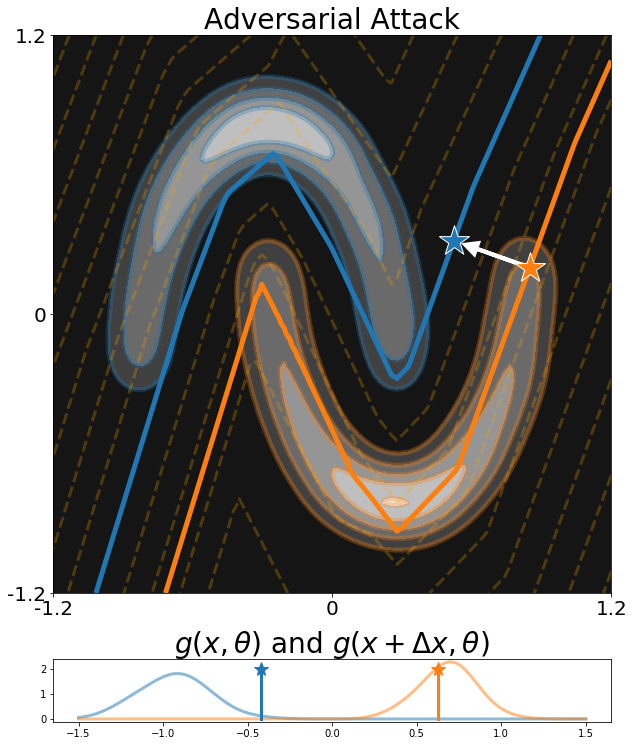

In [30]:
N=100
l=1.
t=np.linspace(-1.2,1.2,101)

fig=plt.figure(figsize=(10,15))
grid = plt.GridSpec(7,7, wspace=.1, hspace=1.)

plt.subplot(grid[:5,:])
plt.contourf(gridx, gridy,Z1+Z2,5,cmap='gray',alpha=1.)
plt.contour(gridx, gridy,Z1,5, colors='C0',linewidths=5,alpha=.3)
plt.contour(gridx, gridy,Z2,5, colors='C1',linewidths=5,alpha=.3)

fgridvec=model(torch.from_numpy(gridvec).type(torch.FloatTensor))[:,1].reshape((100,100))
fgridvec=fgridvec.detach().cpu().numpy()
plt.contour(gridx, gridy,
            fgridvec,
            20, colors='orange',linewidths=3,linestyles='--',alpha=.25)
a=.85
plt.arrow(xtest[0,0], xtest[0,1], a*(-xtest[0,0]+xtest2[0,0]), a*(-xtest[0,1]+xtest2[0,1]), length_includes_head=True,
          head_width=0.05, head_length=0.05,color='w',linewidth=4,zorder=10)

plt.contour(gridx,gridy,fgridvec,levels = [z1],colors=('C1',),linestyles=('-',),linewidths=(5,))
plt.contour(gridx,gridy,fgridvec,levels = [z2],colors=('C0',),linestyles=('-',),linewidths=(5,))
plt.scatter(xtest[0,0],xtest[0,1],s=1000,marker='*',edgecolor='w',c='C1',zorder=90)
plt.scatter(xtest2[0,0],xtest2[0,1],s=1000,marker='*',edgecolor='w',c='C0',zorder=90)
# plt.scatter(z1[:,0],z1[:,1],marker='X',c='C0',s=120)
# plt.scatter(z2[:,0],z2[:,1],marker='o',c='C1',s=100)

plt.axis('square')
plt.xticks([-1.2,0,1.2],[-1.2,0,1.2],fontsize=20)
plt.yticks([-1.2,0,1.2],[-1.2,0,1.2],fontsize=20)

plt.title('Adversarial Attack',fontsize=28)

z1proj=model(z1trch)[:,1].detach().cpu().numpy()
z2proj=model(z2trch)[:,1].detach().cpu().numpy()

mtemp=z1proj.max()
mtemp=max(z2proj.max(),mtemp)


z1proj/=mtemp
z2proj/=mtemp

kde1=KernelDensity(bandwidth=12e-2).fit(z1proj[:,np.newaxis])
kde2=KernelDensity(bandwidth=12e-2).fit(z2proj[:,np.newaxis])

t=np.linspace(-1.5,1.5,1000)
Pc1=np.exp(kde1.score_samples(t[:,np.newaxis]))
Pc2=np.exp(kde2.score_samples(t[:,np.newaxis]))


plt.subplot(grid[5,:])
plt.plot(t,Pc1,linewidth=3,alpha=.5)
plt.plot(t,Pc2,linewidth=3,alpha=.5)
markerline, stemlines, baseline =plt.stem([z1/mtemp],[2],markerfmt='C1*',linefmt='C1-')
plt.setp(stemlines, 'linewidth', 3)
plt.setp(markerline, 'linewidth', 3,'markersize',15)
markerline, stemlines, baseline =plt.stem([z2/mtemp],[2],markerfmt='C0*',linefmt='C0-')
plt.setp(stemlines, 'linewidth', 3)
plt.setp(markerline, 'linewidth', 3,'markersize',15)
# plt.stem(z2proj,np.ones_like(z2proj)/float(N),markerfmt='o',linefmt='C1-')
# plt.xlim([-1.5,1.5])
# plt.ylim([0,.02])
# plt.xticks(fontsize=20)
# plt.yticks([])
plt.title(r'$g(x,\theta)$ and $g(x+\Delta x,\theta)$',fontsize=28)
# plt.legend([r'$g(x_n,\theta)$, $y_n=0$',r'$g(x_n,\theta)$, $y_n=1$'],
#            fontsize=20,bbox_to_anchor=(1.0, 1.2))
# plt.xlabel(r'$t$',fontsize=24)